In [1]:
%load_ext autoreload
%autoreload 2
import sys
from draw_rna.ipynb.draw import draw_struct
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

from models.vienna import ViennaLinearPartition, kT
from models.contrafold import ContrafoldLinearPartition

from utils.dump_forest import dump_forest
from utils.mea_structure import PairProb_MEA
from utils.threshknot import threshknot_pairs, output_bpseq, dotbracket_to_pairs
from utils.dump_bpp import output_bpp_to_file
from utils.shape_data import load_shape_data

from utils.plots import draw_heatmap
from utils.plots import generate_arc_plot_tex

In [2]:
#seq = 'GCGGGAAUAGCUCAGUUGGUAGAGCACGACCUUGCCAAGGUCGGGGUCGCGAGUUCGAGUCUCGUUUCCCGCUCCAGCGGGAAUAGCUCAGUUGGUAGAGCACGACCUUGCCAAGGUCGGGGUCGCGAGUUCGAGUCUCGUUUCCCGCUCCA'
seq = 'GCGGGAAUAGCUCAGUUGGUAGAGCACGACCUUGCCAAGGUCGGGGUCGCGAGUUCGAGUCUCGUUUCCCGCUCCA'
gamma = 3.0
threshknot_threshold = 0.3

model = ViennaLinearPartition(
    seq=seq,
    beam_size=100,
    bpp_cutoff=0.0,
    no_sharp_turn=True,
    SHAPE_data=[] #load_shape_data(self.shape_file_path) if len(self.shape_file_path) > 0 else []
)

model.inside()
model.outside()
model.cal_PairProb()

print(f"Free Energy of Ensemble: { -kT * model.log_partition_coeff() / 100.0 } kcal/mol")

Free Energy of Ensemble: -32.92983957170675 kcal/mol


GCGGGAAUAGCUCAGUUGGUAGAGCACGACCUUGCCAAGGUCGGGGUCGCGAGUUCGAGUCUCGUUUCCCGCUCCA
(((((((..((((........)))).(((((((((....).))))))))((((.......)))).)))))))....


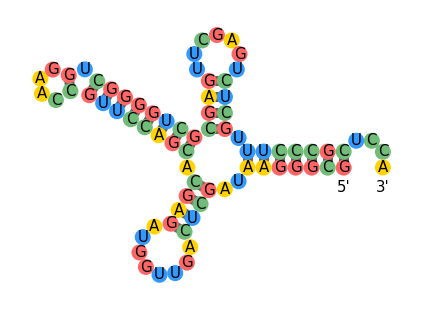

In [3]:
# MEA structure:
struct = PairProb_MEA(model, gamma)
print(seq)
print(struct)
draw_struct(seq, struct)

In [4]:
# Base pairing probs
output_bpp_to_file(model, './scratch/test_bpp_out.txt')

# Forest dump
dump_forest(model, './scratch/test_dump_forest.txt', False)

# Output MEA structure into "bpseq" format
pairs_from_mea = dotbracket_to_pairs(struct)
output_bpseq('./scratch/mea_bpseq.txt', pairs_from_mea, seq)

# Threshknot, and output as bpseq:
tk_pairs = threshknot_pairs(model, threshknot_threshold=threshknot_threshold)
output_bpseq('./scratch/threshknot_bpseq.txt', tk_pairs, seq)

Wrote bpp to ./scratch/test_bpp_out.txt
Dumping (Inside-Outside) Forest to ./scratch/test_dump_forest.txt...
Outputting base pairs in bpseq format to ./scratch/mea_bpseq.txt...
Outputting base pairs in bpseq format to ./scratch/threshknot_bpseq.txt...


In [5]:
import os
from IPython.display import IFrame

bpp_dict = [(i,j,p) for (i,j),p in model.Pij.items()]
bpp_dict.sort(key=lambda x: x[2])

with open('./scratch/bpp_plot.tex', 'w') as f:
    f.write(generate_arc_plot_tex(seq, struct, bpp_dict))
os.system("cd ./scratch && pdflatex ./bpp_plot.tex >/dev/null 2>&1")

IFrame("./scratch/bpp_plot.pdf", width=600, height=600)

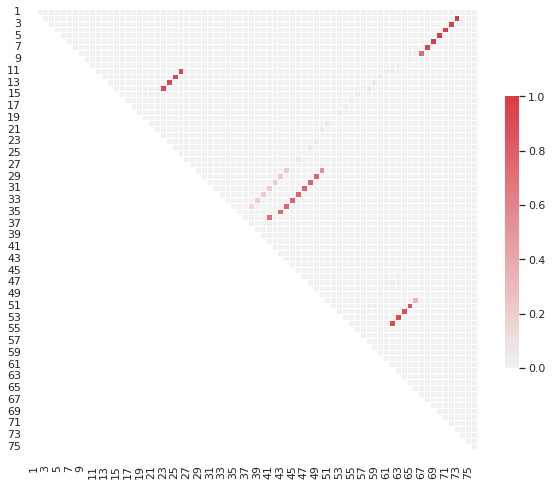

In [6]:
n = len(seq)
Pij = np.zeros((n,n))
for (i,j),p in model.Pij.items():
    Pij[i][j] = p
    
# fig,ax = plt.subplots(1,1,figsize=(10,10))
# ax.imshow(Pij, cmap=sns.diverging_palette(220, 10, as_cmap=True))

fig,ax = draw_heatmap(Pij)